In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications

In [2]:
ds_name = 'oxford_iiit_pet:3.*.*' # 'oxford_iiit_pet'
input_shape = (None, None, 3)

FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
37
['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(TensorShape([500, 500, 3]), TensorShape([500, 500, 1]))

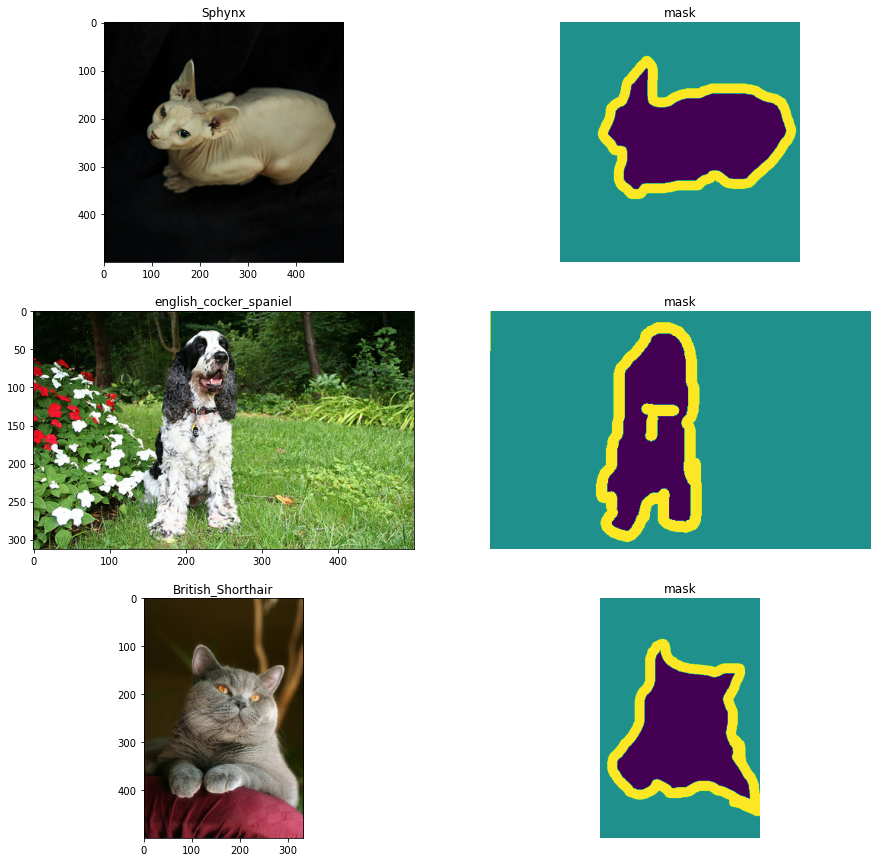

In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    name=ds_name,
    split=['train', 'test[:75%]', 'test[75%:]'], 
    with_info=True, 
    download=True, 
    shuffle_files=False, 
)

print (metadata.features)

num_classes = metadata.features['label'].num_classes
print (num_classes)

class_names = metadata.features['label'].names
print (class_names)

plt.figure(figsize=(15, 15))
i = 0
for datapoint in train_ds.take(3):
    label = datapoint['label']
    image = datapoint['image']
    mask = datapoint['segmentation_mask']
    ax = plt.subplot(3, 2, i + 1)
    plt.title(class_names[label])
    plt.imshow(image.numpy().astype("uint8"))
    ax = plt.subplot(3, 2, i + 2)
    plt.title('mask')
    plt.imshow(mask.numpy().astype("uint8"))
    plt.axis("off")
    i = i + 2
    
iter(train_ds).get_next()['image'].shape, iter(train_ds).get_next()['segmentation_mask'].shape

In [4]:
IMG_SIZE = 128
batch_size = 64
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, resize=False, normalize=False, augment=False):
    
    
    ds = ds.map(lambda x: (x['image'], x['segmentation_mask']))
    
    
    if resize:
        resizing = preprocessing.Resizing(IMG_SIZE,IMG_SIZE)
        ds = ds.map(lambda image, mask: (resizing(image), resizing(mask)))

    
    if augment:
        ds = ds.map(lambda image, mask: (tf.image.flip_left_right(image), tf.image.flip_left_right(mask)) if tf.random.uniform(()) > 0.5 else (image, mask))
        
     
    if normalize:
        ds = ds.map(lambda image, mask: (image/255.0, mask-1)) 
    
    
    ds = ds.batch(batch_size)
    ds = ds.cache()
    
    if shuffle:
        ds = ds.shuffle(BUFFER_SIZE, seed=None)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
        
    return ds

train_ds = prepare(train_ds, shuffle=True, resize=True, normalize=True, augment=True)
val_ds = prepare(val_ds, resize=True, normalize=True)
test_ds = prepare(test_ds, resize=True, normalize=True)

iter(train_ds).get_next()[0].shape, iter(train_ds).get_next()[1].shape

(TensorShape([64, 128, 128, 3]), TensorShape([64, 128, 128, 1]))

In [5]:
backbone = applications.VGG16(input_shape=(128, 128, 3), include_top=False)
backbone.trainable = False
down1 = backbone.get_layer('block1_pool').output
down2 = backbone.get_layer('block2_pool').output
down3 = backbone.get_layer('block3_pool').output
down4 = backbone.get_layer('block4_pool').output
down5 = backbone.get_layer('block5_pool').output

up1 = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(down5)
up1 = layers.BatchNormalization()(up1)
up1 = layers.Concatenate()([up1, down4])


up2 = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(up1)
up2 = layers.BatchNormalization()(up2)
up2 = layers.Concatenate()([up2, down3])


up3 = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(up2)
up3 = layers.BatchNormalization()(up3)
up3 = layers.Concatenate()([up3, down2])


up4 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(up3)
up4 = layers.BatchNormalization()(up4)
up4 = layers.Concatenate()([up4, down1])


up5 = layers.Conv2DTranspose(3, 3, strides=2, padding='same', activation='relu')(up4)


model = models.Model(inputs=backbone.input, outputs=up5)


model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [6]:
%%time

epochs = 7
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/7
58/58 [==============================] - 357s 6s/step - loss: 0.6280 - accuracy: 0.7339 - val_loss: 0.5390 - val_accuracy: 0.8141
Epoch 2/7
58/58 [==============================] - 339s 6s/step - loss: 0.4302 - accuracy: 0.8349 - val_loss: 0.4558 - val_accuracy: 0.8282
Epoch 3/7
58/58 [==============================] - 338s 6s/step - loss: 0.3955 - accuracy: 0.8484 - val_loss: 0.4243 - val_accuracy: 0.8366
Epoch 4/7
58/58 [==============================] - 340s 6s/step - loss: 0.3710 - accuracy: 0.8577 - val_loss: 0.4157 - val_accuracy: 0.8400
Epoch 5/7
58/58 [==============================] - 338s 6s/step - loss: 0.3486 - accuracy: 0.8661 - val_loss: 0.4099 - val_accuracy: 0.8425
Epoch 6/7
58/58 [==============================] - 338s 6s/step - loss: 0.3299 - accuracy: 0.8733 - val_loss: 0.4166 - val_accuracy: 0.8413
Epoch 7/7
58/58 [==============================] - 338s 6s/step - loss: 0.3111 - accuracy: 0.8800 - val_loss: 0.4238 - val_accuracy: 0.8413
Wall time: 39min 48s

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


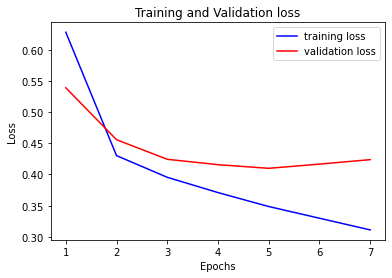

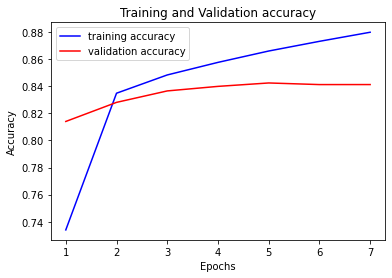

In [7]:
history_dict = history.history
print (history_dict.keys())

loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='training accuracy')
plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

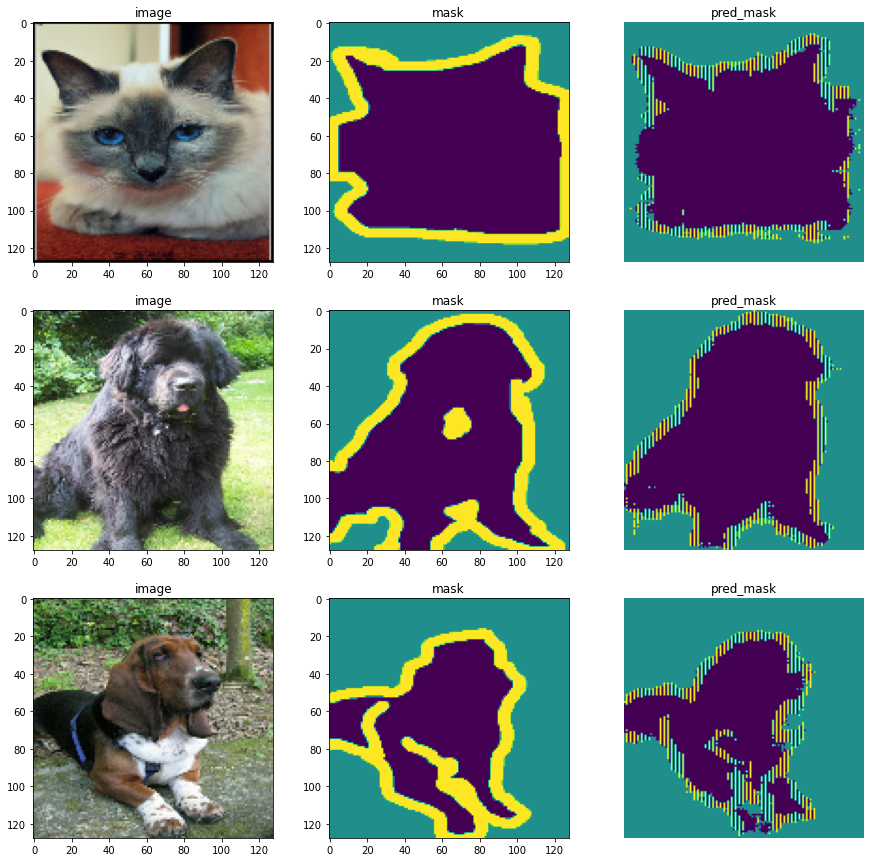

In [8]:
plt.figure(figsize=(15, 15))
i = 0
for image, mask in test_ds.take(3):
    
    ax = plt.subplot(3, 3, i + 1)
    plt.title('image')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    
    ax = plt.subplot(3, 3, i + 2)
    plt.title('mask')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    
    ax = plt.subplot(3, 3, i + 3)
    plt.title('pred_mask')
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[0]))
    
    plt.axis("off")
    i = i + 3